In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
import functools

In [2]:
df = pd.read_csv('Dataset/winequality-red.csv',sep = ';')

In [3]:
def polynomialFeatures(x,degree = 2):
    x_t = x.T
    features = np.ones(len(x))
    for degree in range(1, degree + 1):
        for items in combinations_with_replacement(x_t, degree):
            features = np.vstack((features,functools.reduce(lambda x, y: x * y, items)))
    return features.T

###  #2 Implementthe following function to calculate and return the mean squared error (mse) of two vectors

In [4]:
# Y_true and Y_pred are column vector, which are n-row × 1-col.

def mse(Y_true, Y_pred):
    E = np.array(Y_true).reshape(-1,1) - np.array(Y_pred).reshape(-1,1)
    mse = 1/np.array(Y_true).shape[0] * (E.T.dot(E))
    return mse[(0,0)]

Testing the mse() function

In [5]:
Y_tr = np.array([1, 3, 5, 6]).reshape(-1,1)
Y_pr = np.array([2, 3, 7, 4]).reshape(-1,1)
mse(Y_tr, Y_pr)

2.25

### #3 Implementthe following function to compute training and validation errors.

In [6]:
# function_1 used to split the data into k fold

def k_partition(data,kfold):
    return np.array_split(data,kfold)

In [7]:
# function_2 used to compute the mse for each iteration


def kfold_error(model, X, Y, k_fold, learning_rate = 0.01, epochs = 1000, 
                tol = None, regularizer = None, lambd = 0.0, **kwargs):
    if(Y.shape == (Y.shape[0],)):
        Y = np.expand_dims(Y,axis=1)
    dataset = np.concatenate([X,Y],axis=1)

    k_part = k_partition(dataset, k_fold)   # using the function_1 k_partition
    
    error_training = []
    error_validation = []

    for idx,val in enumerate(k_part):
        validation_Y = val[:,-1]
        validation_X = val[:,:-1]
        train = np.concatenate(np.delete(k_part,idx,0))
        train_Y = train[:,-1]
        train_X = train[:,:-1]          
    
        # with sklearn Linearregression to test the entire function
        # replace it when our modeling function is done.
        reg = model().fit(train_X, train_Y)
        pr_train_Y = reg.predict(train_X)
        pr_validation_Y = reg.predict(validation_X)
        mse_train_Y = mse(train_Y, pr_train_Y)
        mse_validation_Y = mse(validation_Y, pr_validation_Y)
    
#         # using our modeling function
#         model.fit(train_X, train_Y, learning_rate = learning_rate, epochs = epochs, 
#                   tol = tol, regularizer = regularizer, lambd = lambd)
#         pr_train_Y = model.predict(train_X)
#         pr_validation_Y = model.predict(validation_X)
#         mse_train_Y = mse(train_Y, pr_train_Y)
#         mse_validation_Y = mse(validation_Y, pr_validation_Y)

        error_training.append(mse_train_Y)
        error_validation.append(mse_validation_Y)

    # return the average mse for the training and the validation fold.
    return np.array(error_training).mean(), np.array(error_validation).mean()

In [8]:
# final function used to return the training scores and validation scores based on varying training samples. 

def learning_curve(model, X, Y, cv, train_size = 1, learning_rate = 0.01, 
                   epochs = 1000, tol = None, regularizer = None, lambd = 0.0, **kwargs):
    
    
    if type(train_size) == int and train_size > 1: 
        train_size_abs = train_size
    elif train_size > 0 and train_size <= 1:
        train_size_abs = int(train_size * X.shape[0])
    else:
        print(f'unaceptable train_size of {train_size}')
        
    if X.shape[0] % train_size_abs != 0:
        t = X.shape[0] // train_size_abs + 1
    else:
        t = X.shape[0] // train_size_abs
    
    t0 = 1
    num_samples_list = []
    rmse_training_list = []
    rmse_validation_list = []

    while t0 <= t:
        i = t0 * train_size_abs
        if i >= X.shape[0]: i = X.shape[0]
        index = np.arange(i)
        X_split = (X[index])
        Y_split = (Y[index])
        
        # using the function_2 to calculate the mse, and then rmse using k-fold based on varying training samples.
        rmse_tr, rmse_va = np.sqrt(kfold_error(model, X_split, Y_split, cv, train_size = train_size, 
                                               learning_rate = learning_rate, epochs = epochs, tol = tol, 
                                               regularizer = regularizer, lambd = lambd))
        num_samples_list.append(i)
        rmse_training_list.append(rmse_tr)
        rmse_validation_list.append(rmse_va)
        t0 += 1

    result = {'num_samples':pd.Series(num_samples_list), 
              'train_scores':pd.Series(rmse_training_list), 'val_score':pd.Series(rmse_validation_list)}
    learning_curve_elements = pd.DataFrame(result)
    
    return np.array(learning_curve_elements["train_scores"]), \
            np.array(learning_curve_elements["val_score"]), np.array(learning_curve_elements["num_samples"]), \
            learning_curve_elements

Testing the learning_curve function

In [9]:
# using the lineaRegression from sklearn to test the function. 
# when our modeling function is done, we need to replace the sklearn function in the function_2

from sklearn.linear_model import LinearRegression

X = 10 * np.random.rand(63).reshape(63,1)
Y = 20 * np.random.rand(63).reshape(-1,1)
cv = 5
train_size = 10

In [10]:
learning_curve(LinearRegression, X, Y, cv, train_size, learning_rate = 0.01, 
                   epochs = 1000, tol = None, regularizer = None, lambd = 0.0)

(array([4.45551369, 5.09727785, 5.23353373, 5.41114499, 5.3355869 ,
        5.32141421, 5.29677398]),
 array([5.68178707, 5.56595774, 5.43220232, 5.55956031, 5.44085292,
        5.42721566, 5.36510842]),
 array([10, 20, 30, 40, 50, 60, 63], dtype=int64),
    num_samples  train_scores  val_score
 0           10      4.455514   5.681787
 1           20      5.097278   5.565958
 2           30      5.233534   5.432202
 3           40      5.411145   5.559560
 4           50      5.335587   5.440853
 5           60      5.321414   5.427216
 6           63      5.296774   5.365108)

### #4 Implementthe following function to plot the training and validation root mean square error (rmse) values of the data matrix X for various polynomial degree starting from 1 up to the value set by “maxPolynomialDegree”

In [11]:
def plot_polynomial_model_complexity(model, X, Y, cv, maxPolynomialDegree, 
                                     learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs):
    
    poly_list = []
    rmse_training_list = []
    rmse_validation_list = []
    
    for i in range(1, maxPolynomialDegree+1):
        
        # Here should be replaced with our #1 function polynomialFeatures(X, degree)
        X_poly = polynomialFeatures(X, i)
        Y_poly = polynomialFeatures(X, i)
        
        rmse_tr, rmse_va = np.sqrt(kfold_error(model, X_poly, Y_poly, cv, train_size = train_size, 
                                               learning_rate = learning_rate, epochs = epochs, tol = tol, 
                                               regularizer = regularizer, lambd = lambd))
        poly_list.append(i)
        rmse_training_list.append(rmse_tr)
        rmse_validation_list.append(rmse_va)
        
    # plot the RMSE using the list above.
    plt.figure(figsize = (10, 10))
    
    # linewidth and fontsize
    lw = 2
    fontsize = 20
    
    # plot curves
    plt.plot(poly_list, rmse_training_list, 'o-', color='green', lw = lw, label = "Training set") 
    plt.plot(poly_list, rmse_validation_list, 'o-', color='red', lw = lw, label = "Validation set") 
            
    # add title, xlabel, ylabel, and legend. 
    plt.title('RMSE curve', fontsize = fontsize)
    plt.xlabel('Polynomial Degree', fontsize = fontsize)
    plt.ylabel('RMSE', fontsize = fontsize)
    plt.legend(loc="best", fontsize = fontsize)
    plt.xticks(np.arange(1, i+1, 1))
    
    plt.show()

Testing the plot_polynomial_model_complexity function

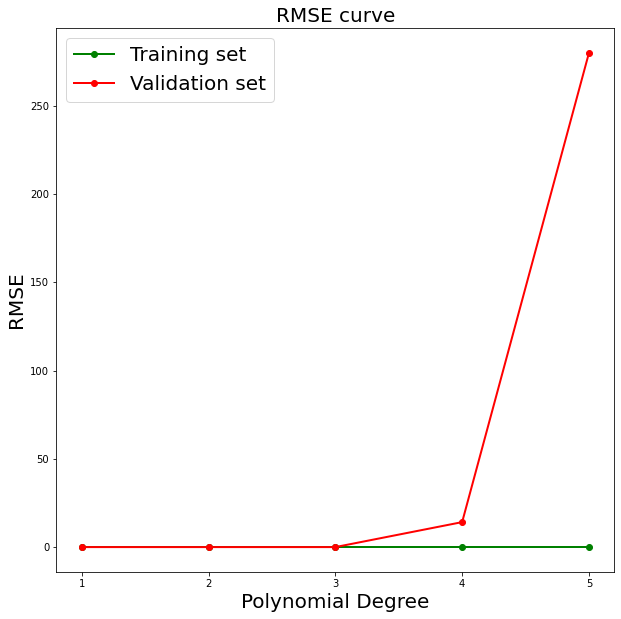

In [12]:
X = 10 * np.random.rand(500).reshape(100,5)
Y = 20 * np.random.rand(100).reshape(-1,1)
cv = 5
poly = 5
plot_polynomial_model_complexity(LinearRegression, X, Y, cv, poly, learning_rate = 0.01, 
                   epochs = 1000, tol = None, regularizer = None, lambd = 0.0)

### #5. Implement a Linear_Regression model class. It should have the following three methods. Note the that “fit” method should implement the batch gradient descent algorithm.

Testing the two functions

In [13]:
import Part_A5 as A5
X = 10 * np.random.rand(63).reshape(63,1)
Y = 20 * np.random.rand(63).reshape(-1,1)
lr = A5.Linear_Regression
lr.fit(lr, X, Y, learning_rate = 0.01, epochs = 1000, tol = None, regularizer = None, lambd = 0.0)
lr.predict(lr, X)

[[1.29028426]
 [1.45075296]
 [0.09440875]
 [5.1092936 ]
 [3.03971172]
 [6.9546092 ]
 [0.08229257]
 [6.74141901]
 [8.3009998 ]
 [3.18622704]
 [2.83195371]
 [7.50883215]
 [7.61727397]
 [4.99330017]
 [5.68968643]
 [7.43710827]
 [7.04107737]
 [1.51385812]
 [4.88168259]
 [5.06072313]
 [6.09695111]
 [9.16802622]
 [9.47789868]
 [9.69926583]
 [3.67835642]
 [6.91586805]
 [3.2539497 ]
 [0.05609216]
 [3.50757529]
 [9.63885731]
 [8.40906352]
 [1.01345318]
 [2.54896538]
 [5.77558453]
 [6.3706377 ]
 [6.67479437]
 [4.7598918 ]
 [1.57082757]
 [5.04294309]
 [6.34677073]
 [4.17023807]
 [3.17638496]
 [1.96957085]
 [7.96781446]
 [4.1493814 ]
 [1.81188967]
 [1.84078716]
 [3.88418731]
 [1.29236358]
 [9.92739533]
 [4.19138617]
 [8.45596889]
 [8.98690876]
 [8.44735383]
 [9.74642224]
 [5.74591635]
 [6.62702994]
 [4.04289127]
 [8.16004887]
 [3.69638747]
 [1.9271733 ]
 [7.53396647]
 [7.01579844]
 [1.        ]]
[1049.10138413 1049.10138413 1049.10138413 1049.10138413 1049.10138413
 1049.10138413 1049.10138413 104

array([[1.29028426],
       [1.45075296],
       [0.09440875],
       [5.1092936 ],
       [3.03971172],
       [6.9546092 ],
       [0.08229257],
       [6.74141901],
       [8.3009998 ],
       [3.18622704],
       [2.83195371],
       [7.50883215],
       [7.61727397],
       [4.99330017],
       [5.68968643],
       [7.43710827],
       [7.04107737],
       [1.51385812],
       [4.88168259],
       [5.06072313],
       [6.09695111],
       [9.16802622],
       [9.47789868],
       [9.69926583],
       [3.67835642],
       [6.91586805],
       [3.2539497 ],
       [0.05609216],
       [3.50757529],
       [9.63885731],
       [8.40906352],
       [1.01345318],
       [2.54896538],
       [5.77558453],
       [6.3706377 ],
       [6.67479437],
       [4.7598918 ],
       [1.57082757],
       [5.04294309],
       [6.34677073],
       [4.17023807],
       [3.17638496],
       [1.96957085],
       [7.96781446],
       [4.1493814 ],
       [1.81188967],
       [1.84078716],
       [3.884